In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [2]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from pandas.core.arrays.sparse.array import ScalarIndexer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.optimizers import Adam
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

In [3]:
%cd /content/drive/MyDrive/IS403/Project/Data/

/content/drive/MyDrive/IS403/Project/Data


# Eval Function

In [4]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [5]:
def train_test_valid(data):
  train_size = int(0.5 * len(data))
  test_size = int(0.3 * len(data))
  val_size = len(data) - train_size - test_size

  train_data = data[:train_size]
  test_data = data[train_size:train_size+test_size]
  valid_data = data[train_size+test_size:]

  return train_data, test_data, valid_data, train_size, test_size, val_size

# AMAZON

## Data

In [ ]:
df_amz = pd.read_csv("AMZN.csv")
df_amz

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,58.602501,58.982498,57.599998,58.117500,58.117500,82142000
1,2017-12-04,58.692501,58.759998,56.400002,56.697498,56.697498,118638000
2,2017-12-05,56.412998,57.963501,56.237000,57.078499,57.078499,81596000
3,2017-12-06,56.899502,57.794498,56.804001,57.617500,57.617500,57066000
4,2017-12-07,57.829498,58.159500,57.549999,57.989498,57.989498,50232000
...,...,...,...,...,...,...,...
1384,2023-06-05,123.360001,125.800003,123.029999,125.300003,125.300003,47950100
1385,2023-06-06,125.070000,127.400002,125.000000,126.610001,126.610001,45695200
1386,2023-06-07,127.010002,127.370003,120.629997,121.230003,121.230003,95663300
1387,2023-06-08,123.010002,125.629997,122.260002,124.250000,124.250000,62159300


## Preprocessing

### Check null and na value

In [ ]:
df_amz.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
df_amz.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [ ]:
print("Date column data type: ", type(df_amz['Date'][0]))
print("Open column data type: ", type(df_amz['Open'][0]))
print("Close column data type: ", type(df_amz['Close'][0]))
print("High column data type: ", type(df_amz['High'][0]))
print("Low column data type: ", type(df_amz['Low'][0]))
print("Adj Close column data type: ", type(df_amz['Adj Close'][0]))
print("Volume column data type: ", type(df_amz['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format & reset index

In [ ]:
df_amz = df_amz.set_index(pd.DatetimeIndex(df_amz['Date'].values))

df_amz.index = pd.to_datetime(df_amz.index,format='%Y-%m-%d')

close_amz = pd.DataFrame(df_amz, columns=['Date', 'Close'])
close_amz.drop('Date', axis = 1, inplace = True)

## EDA

### Get the duration of dataset

In [ ]:
print("Starting date: ",df_amz.iloc[0][0])
print("Ending date: ", df_amz.iloc[-1][0])

Starting date:  2017-12-01
Ending date:  2023-06-09


### Visualize the per day closing price of the stock

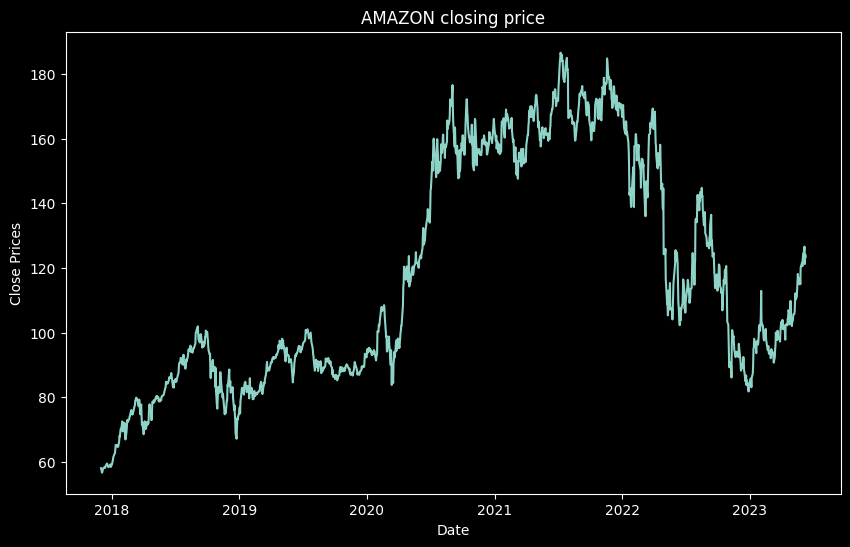

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(close_amz['Close'])
plt.title('AMAZON closing price')
plt.show()

## Train, test, valid

In [ ]:
data_amz = close_amz.values
scaler = MinMaxScaler(feature_range=(0, 1))

sc_train = scaler.fit_transform(data_amz)

train_data, test_data, valid_data, train_size, test_size, val_size = train_test_valid(sc_train)

In [ ]:
x_train, y_train = [], []

for i in range(100, len(train_data)):
    x_train.append(sc_train[i-100:i, 0])
    y_train.append(sc_train[i, 0])

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

## Build & train model

In [ ]:
model = Sequential()

model.add(Conv1D(8, kernel_size = (1), strides = (1),  padding = 'valid',
               activation = 'relu', input_shape = (100,1)))
model.add(MaxPooling1D(pool_size = (1)))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="relu"))

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = '/content/drive/MyDrive/IS403/Project/Model/CNN_AMZ_532.hdf5'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.12313, saving model to /content/drive/MyDrive/IS403/Project/Model/CNN_AMZ_532.hdf5
12/12 - 3s - loss: 0.1231 - 3s/epoch - 271ms/step
Epoch 2/80

Epoch 2: loss improved from 0.12313 to 0.07948, saving model to /content/drive/MyDrive/IS403/Project/Model/CNN_AMZ_532.hdf5
12/12 - 0s - loss: 0.0795 - 154ms/epoch - 13ms/step
Epoch 3/80

Epoch 3: loss improved from 0.07948 to 0.07573, saving model to /content/drive/MyDrive/IS403/Project/Model/CNN_AMZ_532.hdf5
12/12 - 0s - loss: 0.0757 - 170ms/epoch - 14ms/step
Epoch 4/80

Epoch 4: loss improved from 0.07573 to 0.06409, saving model to /content/drive/MyDrive/IS403/Project/Model/CNN_AMZ_532.hdf5
12/12 - 0s - loss: 0.0641 - 159ms/epoch - 13ms/step
Epoch 5/80

Epoch 5: loss did not improve from 0.06409
12/12 - 0s - loss: 0.0643 - 109ms/epoch - 9ms/step
Epoch 6/80

Epoch 6: loss improved from 0.06409 to 0.06187, saving model to /content/drive/MyDrive/IS403/Project/Model/CNN_AMZ_532.hdf5
12/12 - 0s -

## Eval

In [ ]:
y_train = scaler.inverse_transform(y_train)

final_model = load_model('/content/drive/MyDrive/IS403/Project/Model/CNN_AMZ_532.hdf5')

y_train_predict = final_model.predict(x_train)

y_train_predict = scaler.inverse_transform(y_train_predict)

19/19 [==============================] - 1s 5ms/step


In [ ]:
test = close_amz[len(train_data)-100:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = scaler.transform(test)

x_test = []
for i in range(100, test.shape[0]):
    x_test.append(sc_test[i-100:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

y_test = data_amz[train_size:train_size+test_size]  # True values

y_test_predict = final_model.predict(x_test)

y_test_predict = scaler.inverse_transform(y_test_predict)  # Predicted values

13/13 [==============================] - 0s 6ms/step


In [ ]:
val = close_amz[train_size+test_size-100:].values
val = val.reshape(-1, 1)
sc_val = scaler.transform(val)

x_val = []
for i in range(100, val.shape[0]):
    x_val.append(sc_val[i-100:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

y_val = data_amz[train_size+test_size:]  # True values

y_val_predict = final_model.predict(x_val)

y_val_predict = scaler.inverse_transform(y_val_predict)  # Predicted values

9/9 [==============================] - 0s 6ms/step


In [ ]:
train_data = close_amz[:train_size]
test_data = close_amz[train_size:train_size+test_size]
val_data = close_amz[train_size+test_size:]

In [ ]:
eval(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  3.6884165775522084
MAPE:  2.288746023362487
RMSE:  4.809456371589282

** Validate **
MAE:  4.076232186682697
MAPE:  3.697453256442988
RMSE:  5.274963087013642


## Predict

In [ ]:
x_input = sc_train[len(sc_train) - 100:].reshape(1, -1)
print(x_input.shape)

temp_input = list(x_input)
temp_input = temp_input[0].tolist()
print(temp_input)

(1, 100)
[0.2984646662272322, 0.2847589766119052, 0.3122473695417426, 0.3143263005293834, 0.3050865276860706, 0.3117083814450792, 0.3274160422476733, 0.3506695056042365, 0.33765683148393943, 0.3575223465619851, 0.3730760415648524, 0.4328267373946353, 0.3595243177492522, 0.3502075312067563, 0.34966855080992276, 0.3338069165077717, 0.3198701857948948, 0.31501931602441324, 0.3298799878324208, 0.33111192982547455, 0.34235373545469394, 0.31917723189850444, 0.311862354944636, 0.2916888389686668, 0.30100562551116283, 0.3012366127099029, 0.28337300722048475, 0.28537497840775183, 0.2889939061851794, 0.2731322179842187, 0.27282421708629534, 0.2941527845534142, 0.2852979647085686, 0.28375802181759135, 0.2866069204008057, 0.27374821978006547, 0.2620445013520054, 0.2751341891714859, 0.29399874945521776, 0.30416252499230056, 0.3337299028085885, 0.325337057361223, 0.3157892836199869, 0.3381188058814196, 0.3234120998731391, 0.32348911357232235, 0.319023196800308, 0.31833024290391754, 0.312170355842559

In [ ]:
lst_output = []
n_steps = 100
i = 0

while(i < 30):
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i += 1

print(lst_output)

[[0.5212111473083496], [0.5275532603263855], [0.5268570184707642], [0.5297445058822632], [0.5305502414703369], [0.5318347215652466], [0.5331839323043823], [0.5424258708953857], [0.5450568199157715], [0.5535963773727417], [0.5592583417892456], [0.5630981922149658], [0.5631223917007446], [0.5668007135391235], [0.5763126611709595], [0.5791667699813843], [0.5846690535545349], [0.5905206203460693], [0.5943337678909302], [0.5963570475578308], [0.602467954158783], [0.6045299768447876], [0.6061145067214966], [0.6128698587417603], [0.6188274621963501], [0.6191919445991516], [0.6278397440910339], [0.6320415735244751], [0.63582444190979], [0.6403237581253052]]


In [ ]:
datelist_train = df_amz['Date'].astype(str).tolist()

datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

datelist_future = pd.date_range(datelist_train[-1], periods=30, freq='1d').tolist()

In [ ]:
y_pred_future = scaler.inverse_transform(lst_output)

print(y_pred_future)

[[124.38875229]
 [125.21242152]
 [125.12199851]
 [125.49700515]
 [125.60164845]
 [125.76846773]
 [125.94369377]
 [127.14397205]
 [127.48566128]
 [128.59471921]
 [129.3300555 ]
 [129.82874839]
 [129.83189125]
 [130.30960594]
 [131.54495109]
 [131.91562276]
 [132.63022082]
 [133.39018135]
 [133.88540625]
 [134.14817564]
 [134.94181741]
 [135.20961847]
 [135.41540612]
 [136.29274394]
 [137.06647576]
 [137.11381218]
 [138.23692783]
 [138.78263201]
 [139.27392447]
 [139.85826416]]


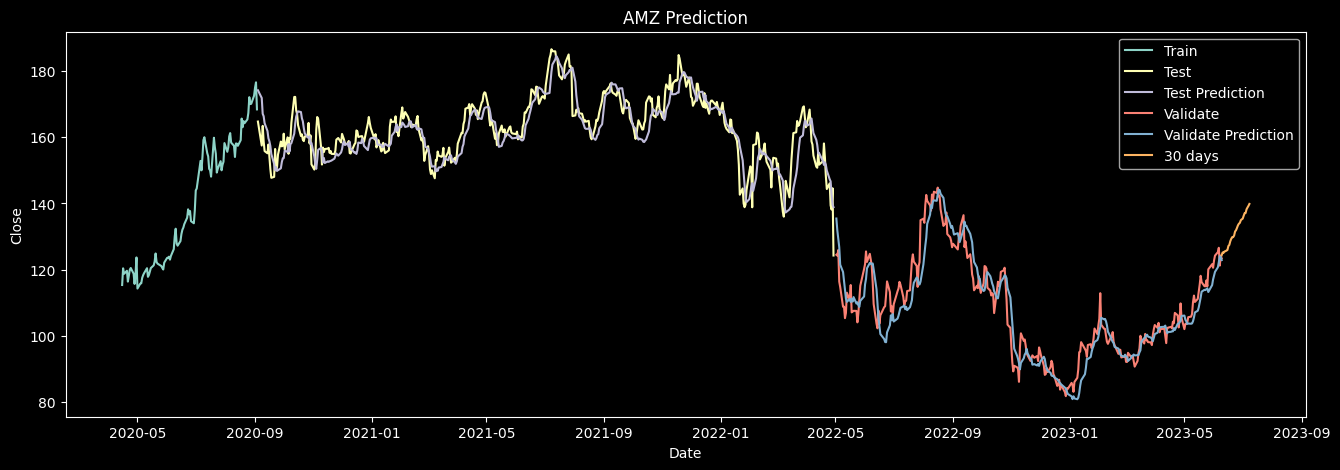

In [ ]:
y_pred_future = scaler.inverse_transform(lst_output)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Close']).set_index(pd.Series(datelist_future))

plt.figure(figsize=(16,5))
plt.plot(train_data.index[train_size-100:], train_data.Close[train_size-100:])
plt.plot(test_data)

plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('AMZ Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction','30 days'])
plt.show()

# NVIDIA

## Data

In [ ]:
df_nvda = pd.read_csv("NVDA.csv")
df_nvda

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,49.827499,50.032501,48.117500,49.419998,48.908009,81154800
1,2017-12-04,50.012501,50.075001,46.125000,46.665001,46.181549,124084400
2,2017-12-05,45.599998,48.174999,45.145000,46.935001,46.448750,98148800
3,2017-12-06,46.424999,47.535000,46.209999,47.314999,46.824821,46703200
4,2017-12-07,47.990002,48.400002,47.529999,47.997501,47.500244,54260000
...,...,...,...,...,...,...,...
1384,2023-06-05,389.089996,395.649994,387.070007,391.709991,391.669464,39609400
1385,2023-06-06,388.299988,391.600006,381.480011,386.540009,386.500000,38872900
1386,2023-06-07,389.149994,394.989990,373.559998,374.750000,374.750000,51199800
1387,2023-06-08,377.239990,388.640015,375.049988,385.100006,385.100006,41777200


## Preprocessing

### Check null and na value

In [ ]:
df_nvda.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
df_nvda.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [ ]:
print("Date column data type: ", type(df_nvda['Date'][0]))
print("Open column data type: ", type(df_nvda['Open'][0]))
print("Close column data type: ", type(df_nvda['Close'][0]))
print("High column data type: ", type(df_nvda['High'][0]))
print("Low column data type: ", type(df_nvda['Low'][0]))
print("Adj Close column data type: ", type(df_nvda['Adj Close'][0]))
print("Volume column data type: ", type(df_nvda['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


## EDA

### Get the duration of dataset

In [ ]:
print("Starting date: ",df_nvda.iloc[0][0])
print("Ending date: ", df_nvda.iloc[-1][0])

Starting date:  2017-12-01
Ending date:  2023-06-09


### Visualize the per day closing price of the stock

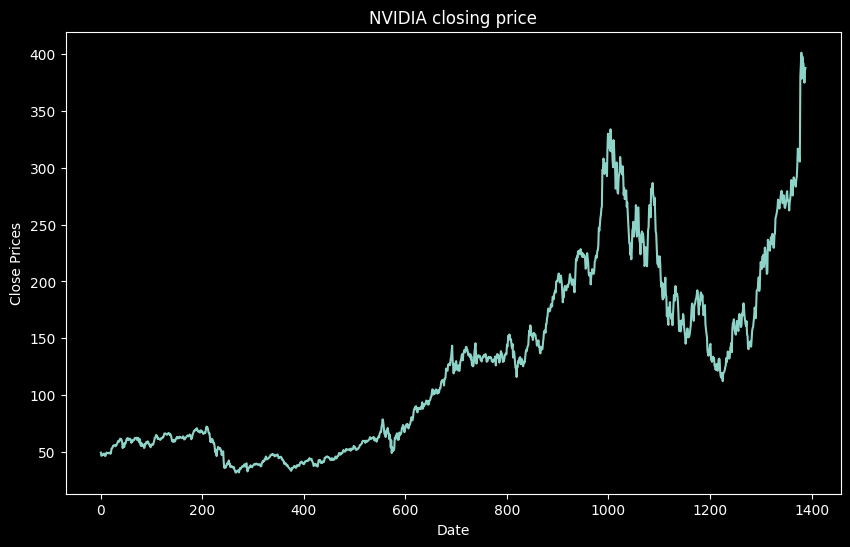

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_nvda['Close'])
plt.title('NVIDIA closing price')
plt.show()

## Train, test, valid

### Convert date from string to date format & reset index

In [ ]:
df_nvda = df_nvda.set_index(pd.DatetimeIndex(df_nvda['Date'].values))

df_nvda.index = pd.to_datetime(df_nvda.index,format='%Y-%m-%d')

close_nvda = pd.DataFrame(df_nvda, columns=['Date', 'Close'])
close_nvda.drop('Date', axis = 1, inplace = True)

### Split

In [ ]:
data_nvda = close_nvda.values
scaler = MinMaxScaler(feature_range=(0, 1))

sc_train = scaler.fit_transform(data_nvda)

train_data, test_data, valid_data, train_size, test_size, val_size = train_test_valid(sc_train)

In [ ]:
x_train, y_train = [], []

for i in range(100, len(train_data)):
    x_train.append(sc_train[i-100:i, 0])
    y_train.append(sc_train[i, 0])

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

## Build & train model

In [ ]:
model = Sequential()

model.add(Conv1D(8, kernel_size = (1), strides = (1),  padding = 'valid',
               activation = 'relu', input_shape = (100,1)))
model.add(MaxPooling1D(pool_size = (1)))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="relu"))

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = '/content/drive/MyDrive/IS403/Project/Model/CNN_NVDA_532.hdf5'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.03540, saving model to /content/drive/MyDrive/IS403/Project/Model/CNN_NVDA_532.hdf5
12/12 - 1s - loss: 0.0354 - 816ms/epoch - 68ms/step
Epoch 2/80

Epoch 2: loss improved from 0.03540 to 0.02543, saving model to /content/drive/MyDrive/IS403/Project/Model/CNN_NVDA_532.hdf5
12/12 - 0s - loss: 0.0254 - 83ms/epoch - 7ms/step
Epoch 3/80

Epoch 3: loss improved from 0.02543 to 0.01829, saving model to /content/drive/MyDrive/IS403/Project/Model/CNN_NVDA_532.hdf5
12/12 - 0s - loss: 0.0183 - 81ms/epoch - 7ms/step
Epoch 4/80

Epoch 4: loss improved from 0.01829 to 0.01696, saving model to /content/drive/MyDrive/IS403/Project/Model/CNN_NVDA_532.hdf5
12/12 - 0s - loss: 0.0170 - 76ms/epoch - 6ms/step
Epoch 5/80

Epoch 5: loss improved from 0.01696 to 0.01524, saving model to /content/drive/MyDrive/IS403/Project/Model/CNN_NVDA_532.hdf5
12/12 - 0s - loss: 0.0152 - 112ms/epoch - 9ms/step
Epoch 6/80

Epoch 6: loss improved from 0.01524 to 0.01386, saving

## Eval

In [ ]:
y_train = scaler.inverse_transform(y_train)

final_model = load_model('/content/drive/MyDrive/IS403/Project/Model/CNN_NVDA_532.hdf5')

y_train_predict = final_model.predict(x_train)

y_train_predict = scaler.inverse_transform(y_train_predict)

19/19 [==============================] - 0s 2ms/step


In [ ]:
test = close_nvda[len(train_data)-100:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = scaler.transform(test)

x_test = []
for i in range(100, test.shape[0]):
    x_test.append(sc_test[i-100:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

y_test = data_nvda[train_size:train_size+test_size]  # True values

y_test_predict = final_model.predict(x_test)

y_test_predict = scaler.inverse_transform(y_test_predict)  # Predicted values

13/13 [==============================] - 0s 2ms/step


In [ ]:
val = close_nvda[train_size+test_size-100:].values
val = val.reshape(-1, 1)
sc_val = scaler.transform(val)

x_val = []
for i in range(100, val.shape[0]):
    x_val.append(sc_val[i-100:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

y_val = data_nvda[train_size+test_size:]  # True values

y_val_predict = final_model.predict(x_val)

y_val_predict = scaler.inverse_transform(y_val_predict)  # Predicted values

9/9 [==============================] - 0s 2ms/step


In [ ]:
train_data = close_nvda[:train_size]
test_data = close_nvda[train_size:train_size+test_size]
val_data = close_nvda[train_size+test_size:]

In [ ]:
eval(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  24.73078854827529
MAPE:  12.333698237759465
RMSE:  29.73248206804638

** Validate **
MAE:  34.82052922186695
MAPE:  19.303020880229003
RMSE:  37.95439353433561


## Predict

In [ ]:
x_input = sc_train[len(sc_train) - 100:].reshape(1, -1)
print(x_input.shape)

temp_input = list(x_input)
temp_input = temp_input[0].tolist()
print(temp_input)

(1, 100)
[0.3844696208562417, 0.36789949509528463, 0.3969784073067528, 0.4336383806372873, 0.43558780671960007, 0.4371581809643491, 0.4501272831318277, 0.4653706638342988, 0.4327990509882107, 0.44295229773185796, 0.4810201987743081, 0.5017599055785958, 0.48527104369704244, 0.4849732124183629, 0.5143228562160688, 0.5151892855575873, 0.5187632067510913, 0.4897384560190524, 0.5038988805937163, 0.5359289950694073, 0.5303243812066543, 0.5096929973612253, 0.49306875073382583, 0.4732225323505116, 0.4759029624155099, 0.5546921733914079, 0.5444577060888763, 0.5502788846433726, 0.5425624414859929, 0.528537401657175, 0.5452158097640036, 0.5608111832245837, 0.5517138714347433, 0.5445118675683056, 0.5686901135277839, 0.5485190047863352, 0.5357665079235869, 0.5357936103235613, 0.5654952441718434, 0.5699626564938535, 0.6055125712966062, 0.610494420202026, 0.615232602015728, 0.6233280970106715, 0.6306113674640453, 0.6501868569686545, 0.6390318367506296, 0.6323171264546403, 0.6290410338322833, 0.644582

In [ ]:
lst_output = []
n_steps = 100
i = 0

while(i < 30):
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i += 1

print(lst_output)

[[0.8391206860542297], [0.8096622228622437], [0.7753092050552368], [0.7343034744262695], [0.7006293535232544], [0.670788049697876], [0.6255393624305725], [0.589790403842926], [0.5627148151397705], [0.523178219795227], [0.4891200363636017], [0.45492756366729736], [0.42120954394340515], [0.3910292685031891], [0.3633801341056824], [0.32930535078048706], [0.30326950550079346], [0.2835373282432556], [0.256767213344574], [0.23440472781658173], [0.2102987915277481], [0.18648140132427216], [0.1713707149028778], [0.16465842723846436], [0.14943456649780273], [0.13630500435829163], [0.12110825628042221], [0.10436128079891205], [0.08424673974514008], [0.06037045270204544]]


In [ ]:
datelist_train = df_nvda['Date'].astype(str).tolist()

datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

datelist_future = pd.date_range(datelist_train[-1], periods=30, freq='1d').tolist()

In [ ]:
y_pred_future = scaler.inverse_transform(lst_output)

print(y_pred_future)

[[341.6908216 ]
 [330.81063325]
 [318.12269017]
 [302.97763423]
 [290.54043492]
 [279.51884821]
 [262.80669874]
 [249.60317891]
 [239.60308138]
 [225.00063585]
 [212.42158689]
 [199.79293954]
 [187.33952664]
 [176.19274416]
 [165.98081328]
 [153.39563332]
 [143.77955461]
 [136.49167256]
 [126.60439873]
 [118.34503866]
 [109.44175251]
 [100.64503797]
 [ 95.06405727]
 [ 92.58494105]
 [ 86.96216055]
 [ 82.11288827]
 [ 76.50012156]
 [ 70.31479388]
 [ 62.88568959]
 [ 54.0672221 ]]


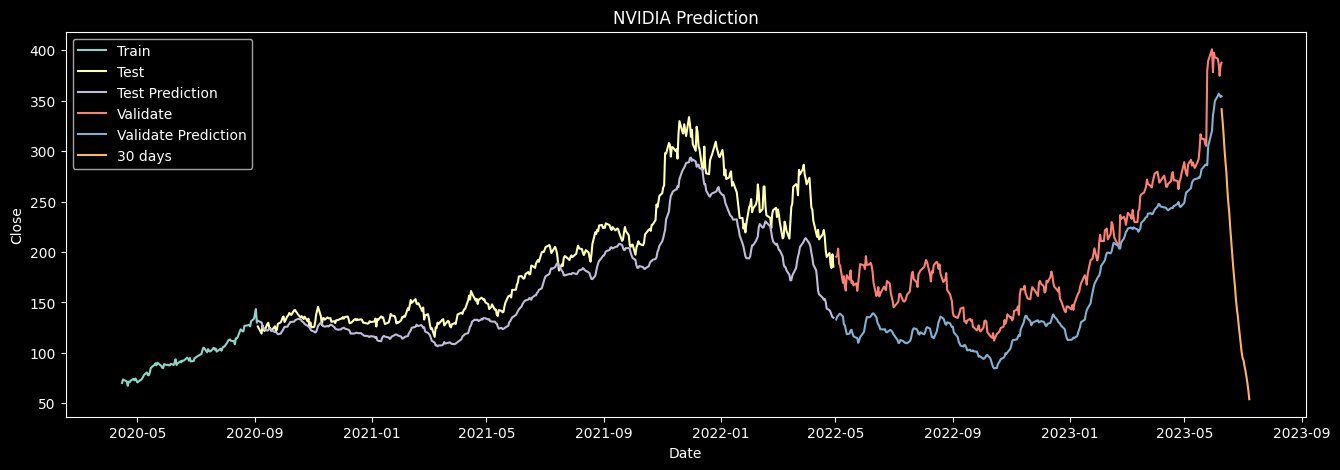

In [ ]:
y_pred_future = scaler.inverse_transform(lst_output)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Close']).set_index(pd.Series(datelist_future))

plt.figure(figsize=(16,5))

plt.plot(train_data.index[train_size-100:], train_data.Close[train_size-100:])
plt.plot(test_data)

plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('NVIDIA Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction','30 days'])
plt.show()

# TESLA

## Data

In [6]:
df_tsla = pd.read_csv("TSLA.csv")
df_tsla

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,20.362667,20.688000,20.336666,20.435333,20.435333,64393500
1,2017-12-04,20.433332,20.551332,20.040667,20.346666,20.346666,87526500
2,2017-12-05,20.133333,20.533333,20.066668,20.246668,20.246668,69697500
3,2017-12-06,20.006666,20.892668,20.000000,20.884001,20.884001,107929500
4,2017-12-07,20.799999,21.242001,20.736668,20.749332,20.749332,71709000
...,...,...,...,...,...,...,...
1384,2023-06-05,217.800003,221.289993,214.520004,217.610001,217.610001,151143100
1385,2023-06-06,216.139999,221.910004,212.529999,221.309998,221.309998,146911600
1386,2023-06-07,228.000000,230.830002,223.199997,224.570007,224.570007,185710800
1387,2023-06-08,224.220001,235.229996,223.009995,234.860001,234.860001,164489700


## Preprocessing

### Check null and na value

In [7]:
df_tsla.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
df_tsla.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [9]:
print("Date column data type: ", type(df_tsla['Date'][0]))
print("Open column data type: ", type(df_tsla['Open'][0]))
print("Close column data type: ", type(df_tsla['Close'][0]))
print("High column data type: ", type(df_tsla['High'][0]))
print("Low column data type: ", type(df_tsla['Low'][0]))
print("Adj Close column data type: ", type(df_tsla['Adj Close'][0]))
print("Volume column data type: ", type(df_tsla['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


## EDA

### Get the duration of dataset

In [10]:
print("Starting date: ",df_tsla.iloc[0][0])
print("Ending date: ", df_tsla.iloc[-1][0])

Starting date:  2017-12-01
Ending date:  2023-06-09


### Visualize the per day closing price of the stock

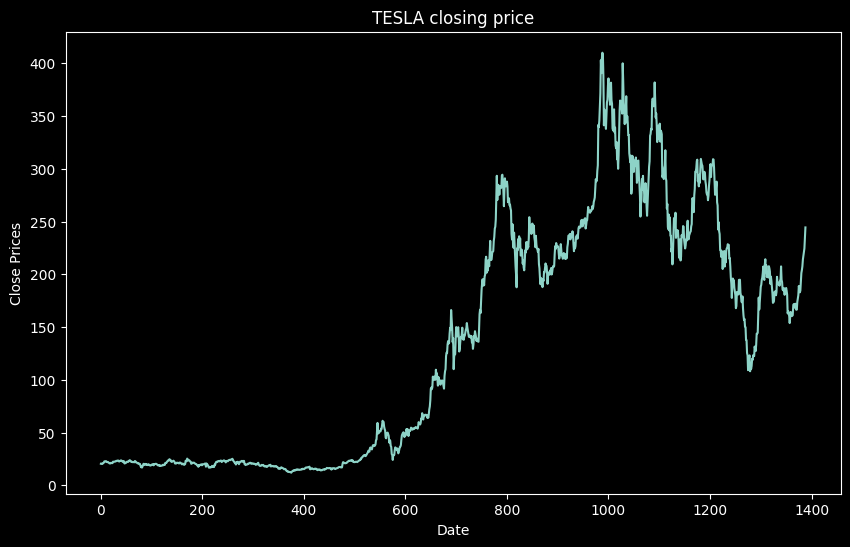

In [11]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_tsla['Close'])
plt.title('TESLA closing price')
plt.show()

## Train, test, valid

### Convert date from string to date format & reset index

In [12]:
df_tsla = df_tsla.set_index(pd.DatetimeIndex(df_tsla['Date'].values))

df_tsla.index = pd.to_datetime(df_tsla.index,format='%Y-%m-%d')

close_tsla = pd.DataFrame(df_tsla, columns=['Date', 'Close'])
close_tsla.drop('Date', axis = 1, inplace = True)

### Split

In [13]:
data_tsla = close_tsla.values
scaler = MinMaxScaler(feature_range=(0, 1))

sc_train = scaler.fit_transform(data_tsla)

train_data, test_data, valid_data, train_size, test_size, val_size = train_test_valid(sc_train)

In [14]:
x_train, y_train = [], []

for i in range(100, len(train_data)):
    x_train.append(sc_train[i-100:i, 0])
    y_train.append(sc_train[i, 0])

In [15]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

## Build model

In [16]:
model = Sequential()

model.add(Conv1D(8, kernel_size = (1), strides = (1),  padding = 'valid',
               activation = 'relu', input_shape = (100,1)))
model.add(MaxPooling1D(pool_size = (1)))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="relu"))

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = '/content/drive/MyDrive/IS403/Project/Model/CNN_TSLA_532.hdf5'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.02199, saving model to /content/drive/MyDrive/IS403/Project/Model/CNN_TSLA_532.hdf5
12/12 - 2s - loss: 0.0220 - 2s/epoch - 154ms/step
Epoch 2/80

Epoch 2: loss improved from 0.02199 to 0.01376, saving model to /content/drive/MyDrive/IS403/Project/Model/CNN_TSLA_532.hdf5
12/12 - 0s - loss: 0.0138 - 121ms/epoch - 10ms/step
Epoch 3/80

Epoch 3: loss did not improve from 0.01376
12/12 - 0s - loss: 0.0145 - 64ms/epoch - 5ms/step
Epoch 4/80

Epoch 4: loss improved from 0.01376 to 0.01162, saving model to /content/drive/MyDrive/IS403/Project/Model/CNN_TSLA_532.hdf5
12/12 - 0s - loss: 0.0116 - 81ms/epoch - 7ms/step
Epoch 5/80

Epoch 5: loss did not improve from 0.01162
12/12 - 0s - loss: 0.0119 - 62ms/epoch - 5ms/step
Epoch 6/80

Epoch 6: loss did not improve from 0.01162
12/12 - 0s - loss: 0.0129 - 55ms/epoch - 5ms/step
Epoch 7/80

Epoch 7: loss improved from 0.01162 to 0.01147, saving model to /content/drive/MyDrive/IS403/Project/Model/CNN_TSL

## Eval

In [17]:
y_train = scaler.inverse_transform(y_train)

final_model = load_model('/content/drive/MyDrive/IS403/Project/Model/CNN_TSLA_532.hdf5')

y_train_predict = final_model.predict(x_train)

y_train_predict = scaler.inverse_transform(y_train_predict)

19/19 [==============================] - 0s 2ms/step


In [18]:
test = close_tsla[len(train_data)-100:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = scaler.transform(test)

x_test = []
for i in range(100, test.shape[0]):
    x_test.append(sc_test[i-100:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

y_test = data_tsla[train_size:train_size+test_size]  # True values

y_test_predict = final_model.predict(x_test)

y_test_predict = scaler.inverse_transform(y_test_predict)  # Predicted values

13/13 [==============================] - 0s 2ms/step


In [19]:
val = close_tsla[train_size+test_size-100:].values
val = val.reshape(-1, 1)
sc_val = scaler.transform(val)

x_val = []
for i in range(100, val.shape[0]):
    x_val.append(sc_val[i-100:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

y_val = data_tsla[train_size+test_size:]  # True values

y_val_predict = final_model.predict(x_val)

y_val_predict = scaler.inverse_transform(y_val_predict)  # Predicted values

9/9 [==============================] - 0s 2ms/step


In [20]:
train_data = close_tsla[:train_size]
test_data = close_tsla[train_size:train_size+test_size]
val_data = close_tsla[train_size+test_size:]

In [21]:
eval(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  26.63705804152621
MAPE:  10.607791287534441
RMSE:  32.68266127139108

** Validate **
MAE:  43.24997880124678
MAPE:  21.991289031522463
RMSE:  48.21340117080517


## Predict

In [22]:
x_input = sc_train[len(sc_train) - 100:].reshape(1, -1)
print(x_input.shape)

temp_input = list(x_input)
temp_input = temp_input[0].tolist()
print(temp_input)

(1, 100)
[0.2935610919087891, 0.28951625624473243, 0.30521824829340444, 0.33117050577608703, 0.3315222278856585, 0.33287886492475144, 0.3726740212084118, 0.4169661752561185, 0.388727737878974, 0.405208541196304, 0.42578443911383995, 0.4430189455864624, 0.44731499051242923, 0.4593238715189349, 0.4644741324478555, 0.47572930778674993, 0.4908786248877709, 0.46467512045839715, 0.45902240332087524, 0.49572738244616965, 0.508263865459423, 0.4776135468325906, 0.49336579781741197, 0.46588102339846027, 0.4746490308323511, 0.4776889515668864, 0.4646500123450317, 0.49165743866874756, 0.4868337917360329, 0.4794475671393814, 0.4496263187173563, 0.4669361922394936, 0.45693717626449293, 0.44161205463585756, 0.4272666971139597, 0.40445483804101157, 0.40576125382873596, 0.40837405023172263, 0.4304322061493784, 0.42337259554893286, 0.4326179485657408, 0.4225686736545907, 0.4304070955236941, 0.4664086279175268, 0.45025439839930315, 0.4529425970242669, 0.44839530766392766, 0.45191253880891785, 0.445330273

In [23]:
lst_output = []
n_steps = 100
i = 0

while(i < 30):
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i += 1

print(lst_output)

[[0.6108200550079346], [0.6281353831291199], [0.6499127149581909], [0.6631153225898743], [0.6807796955108643], [0.6988012790679932], [0.7221601009368896], [0.7438551783561707], [0.7589061856269836], [0.7782008051872253], [0.7985450625419617], [0.8194159865379333], [0.8341735601425171], [0.8530082106590271], [0.8703582882881165], [0.8867981433868408], [0.8974159955978394], [0.9102947115898132], [0.9164217114448547], [0.9267995953559875], [0.935610294342041], [0.9434390664100647], [0.9546980261802673], [0.9639831185340881], [0.979171097278595], [0.9929071664810181], [1.002798318862915], [1.0137426853179932], [1.0237839221954346], [1.0357215404510498]]


In [24]:
datelist_train = df_tsla['Date'].astype(str).tolist()

datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

datelist_future = pd.date_range(datelist_train[-1], periods=30, freq='1d').tolist()

In [25]:
y_pred_future = scaler.inverse_transform(lst_output)

print(y_pred_future)

[[255.06133408]
 [261.95350422]
 [270.62172438]
 [275.87687273]
 [282.9079762 ]
 [290.08126332]
 [299.37897766]
 [308.01445738]
 [314.00534026]
 [321.68534493]
 [329.78314603]
 [338.09058082]
 [343.96466576]
 [351.46158496]
 [358.36758675]
 [364.91128478]
 [369.13760053]
 [374.26382749]
 [376.70261035]
 [380.83340944]
 [384.34040833]
 [387.45656233]
 [391.93806368]
 [395.63388948]
 [401.6792923 ]
 [407.14677899]
 [411.08384011]
 [415.44012116]
 [419.43692171]
 [424.18855538]]


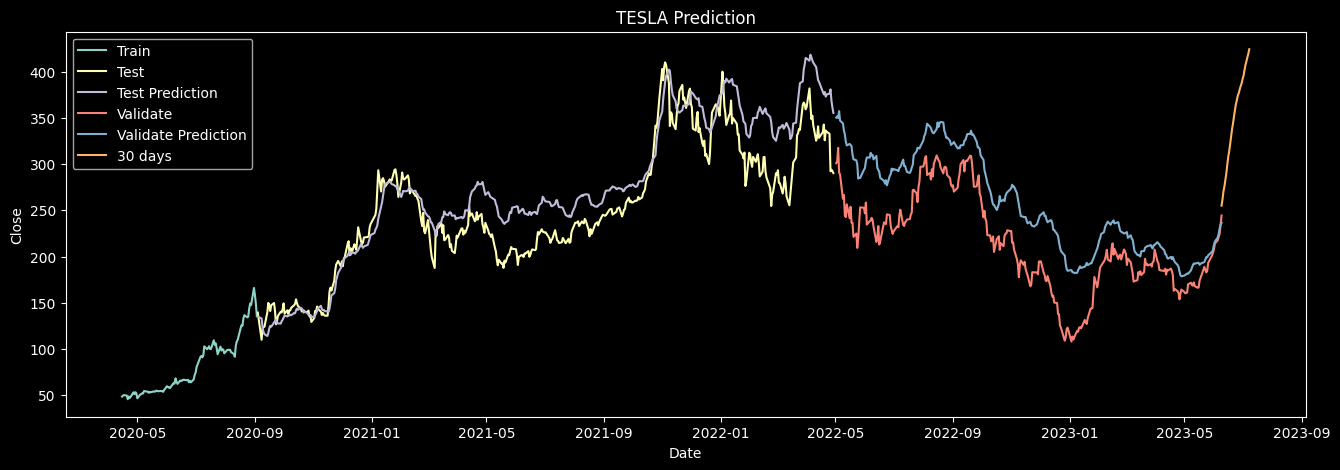

In [26]:
y_pred_future = scaler.inverse_transform(lst_output)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Close']).set_index(pd.Series(datelist_future))

plt.figure(figsize=(16,5))

plt.plot(train_data.index[train_size-100:], train_data.Close[train_size-100:])
plt.plot(test_data)

plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('TESLA Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction','30 days'])
plt.show()